# **NLP Preprocessing and Modelling**

### **By:** Jiro Amato

### **Date:** June, 20, 2024

---

In this notebook, we wll be going through preprocessing and modelling our training dataset for the sentiment analysis model. This dataset contains 4,840 financial articles that have been classified as positive, neutral or negative by 16 financial professionals. It is crucial to complete this step as it sets the foundation for the rest of the model. We will be looking through four base models: Logistic Regression, Decision Tree, K-Nearest Neighbor and Naïve Bayes as well as one upsampling technique: SMOTE.

### ***Data Dictionary***

**Column Name:**   

- `Headline:` The headline of the news article
- `Sentiment:` Classifications by positive, neutral or negative. These classifications were agreed upon by 16 professionals in the Finance domain.

**Table of contents**<a id='toc0_'></a>    
- 1. [**Loading the data**](#toc1_)    
  - 1.1. [***Simplifying a multi-class problem into a binary problem***](#toc1_1_)    
  - 1.2. [***Tokenizer***](#toc1_2_)    
- 2. [**Base Models**](#toc2_)    
  - 2.1. [***Logistic Regression***](#toc2_1_)    
    - 2.1.1. [***Best Hyparameter (LR)***](#toc2_1_1_)    
  - 2.2. [***Decision Tree***](#toc2_2_)    
    - 2.2.1. [***Best Hyperparameter (DT)***](#toc2_2_1_)    
  - 2.3. [***K-Nearest Neighbors***](#toc2_3_)    
    - 2.3.1. [***Best Hyperparameter (KNN)***](#toc2_3_1_)    
  - 2.4. [***Naïve Bayes***](#toc2_4_)    
    - 2.4.1. [***Best Hyperparameter (NB)***](#toc2_4_1_)    
  - 2.5. [**Comparing all base models**](#toc2_5_)    
- 3. [**Model Evaluation**](#toc3_)    
  - 3.1. [***Logistic Regression***](#toc3_1_)    
    - 3.1.1. [***Confusion Matrix***](#toc3_1_1_)    
    - 3.1.2. [***Classification Report***](#toc3_1_2_)    
    - 3.1.3. [***ROC and PR Curve***](#toc3_1_3_)    
  - 3.2. [***Decision Tree***](#toc3_2_)    
    - 3.2.1. [***Confusion Matrix***](#toc3_2_1_)    
    - 3.2.2. [***Classification Report***](#toc3_2_2_)    
    - 3.2.3. [***ROC and PR Curve***](#toc3_2_3_)    
  - 3.3. [***KNN***](#toc3_3_)    
    - 3.3.1. [***Confusion Matrix***](#toc3_3_1_)    
    - 3.3.2. [***Classification Report***](#toc3_3_2_)    
    - 3.3.3. [***ROC and PR Curve***](#toc3_3_3_)    
  - 3.4. [***Naïve Bayes***](#toc3_4_)    
    - 3.4.1. [***Confusion Matrix***](#toc3_4_1_)    
    - 3.4.2. [***Classification Report***](#toc3_4_2_)    
    - 3.4.3. [***ROC Curve***](#toc3_4_3_)    
  - 3.5. [***Insights***](#toc3_5_)    
- 4. [**Dealing with Imbalanced Data**](#toc4_)    
  - 4.1. [***SMOTE***](#toc4_1_)    
    - 4.1.1. [***Logistic Regression***](#toc4_1_1_)    
      - 4.1.1.1. [***Evaluation***](#toc4_1_1_1_)    
        - 4.1.1.1.1. [***Confusion Matrix and Classification Report***](#toc4_1_1_1_1_)    
        - 4.1.1.1.2. [***ROC and PR Curve***](#toc4_1_1_1_2_)    
    - 4.1.2. [***Decision Tree***](#toc4_1_2_)    
      - 4.1.2.1. [***Evaluation***](#toc4_1_2_1_)    
        - 4.1.2.1.1. [***Confusion Matrix and Classification Report***](#toc4_1_2_1_1_)    
        - 4.1.2.1.2. [***ROC and PR Curve***](#toc4_1_2_1_2_)    
    - 4.1.3. [***KNN***](#toc4_1_3_)    
      - 4.1.3.1. [***Evaluation***](#toc4_1_3_1_)    
        - 4.1.3.1.1. [***Confusion Matrix and Classification Report***](#toc4_1_3_1_1_)    
    - 4.1.4. [***Naïve Bayes***](#toc4_1_4_)    
      - 4.1.4.1. [***Evaluation***](#toc4_1_4_1_)    
        - 4.1.4.1.1. [***Confusion Matrix and Classification Report***](#toc4_1_4_1_1_)    
        - 4.1.4.1.2. [***ROC and PR Curve***](#toc4_1_4_1_2_)    
- 5. [**Conclusion/Next Steps**](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Importing necessary libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  ML related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# For memory caching
from tempfile import mkdtemp

# For Train/Test splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Sampling methods
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN

# NLP specific libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. <a id='toc1_'></a>[**Loading the data**](#toc0_)

In [3]:
df = pd.read_csv('../data/df_clean.csv', index_col=0)
df.head()

,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


## 1.1. <a id='toc1_1_'></a>[***Simplifying a multi-class problem into a binary problem***](#toc0_)

In [4]:
# Mapping sentiments into binary (consolidating neutral into negative)

df['Sentiment'] = np.where(df['Sentiment'] == 'positive', 1, 0)

# Sanity check
df['Sentiment'].value_counts()

Sentiment
0    3477
1    1363
Name: count, dtype: int64

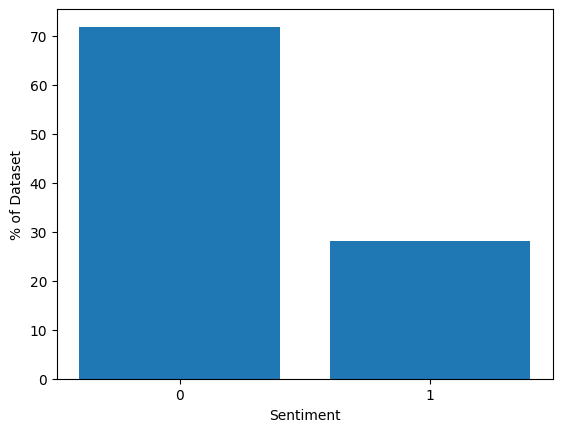

Class imbalance: [0.72 0.28]


In [6]:
# Class imbalance

values, counts = np.unique(df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Dataset')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

As you can see the data is very imbalanced favouring the Negative/Neutral class at 72% while the Positive class is at 28%. We can suspect that model performance will be affected and will perform poorly in identifying the Positive class. We will continue in modelling with the current imbalance to see the baseline performance. Afterward, we will make the necessary changes to handle the imbalance classes.

## 1.2. <a id='toc1_2_'></a>[***Tokenizer***](#toc0_)

From the `1-NLP-Cleaning-EDA` notebook we created our own tokenizer. The components are below:

1. Standardization: Transforming text data into all lowercase and take out the punctuations
2. Tokenization: Splitting the documents into individual words
3. Stop-word removal: Removing words without significant meaning such as 'the' and 'like'
4. Lemmatization: Reducing words to their lemma (root)
5. Removal of short tokens with 1 or 2 elements

In [7]:
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def my_tokenizer(sentence):
    # transform string into lower case and take out punctuations
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '').lower()

    # tokenization
    listofwords = sentence.split(' ')
    lemmatized_words = []

    # removal of stop-words
    for word in listofwords:
        if word not in stop_words and (word != ''):
            # lemmatizing
            lemma = wnl.lemmatize(word)
            lemmatized_words.append(lemma)
            
    # Removing any other words with 1 or 2 letters that are insignificant        
    tokenized_list = [word for word in lemmatized_words if (len(word) != 1) and (len(word) != 2)]

    return tokenized_list

In [8]:
# Extracting columns

X = df['Headline']
y = df['Sentiment']

# Vectorizing
bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer, ngram_range=(1, 1))

# Fitting
bagofwords.fit(X)
X_bow = bagofwords.transform(X)

X_bow = pd.DataFrame(data=X_bow.toarray(), columns=bagofwords.get_feature_names_out())

X_bow

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000,021,050,100,1000,10000,100000,105,110,112,...,yard,year,yearonyear,yesterday,yet,yit,york,zinc,zone,àland
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


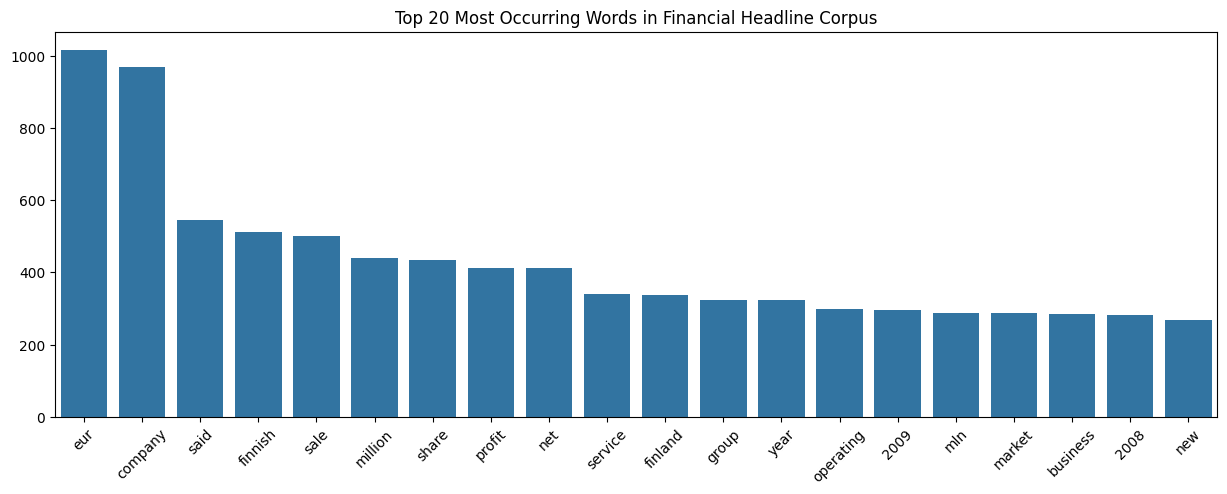

In [263]:
# Plotting most occuring words in the corpus of financial headlines
plt.figure(figsize=(15,5))
sns.barplot(X_bow.sum(axis=0).sort_values(ascending=False).head(20))
plt.title('Top 20 Most Occurring Words in Financial Headline Corpus')
plt.xticks(rotation=45)
plt.show()

# 2. <a id='toc2_'></a>[**Base Models**](#toc0_)

This section looks at 4 base models that will be explored to apply Sentiment Analysis. The four models include:

1. [Logistic Regression](#logistic-regression)
2. [Decision Tree](#decision-tree)
3. [K-Nearest Neighbors](#k-nearest-neighbors)
4. [Naïve Bayes](2-NLP-Preprocessing-Modelling.ipynb#naïve-bayes)

## 2.1. <a id='toc2_1_'></a>[***Logistic Regression***](#toc0_)

For this model we will tune the hyperparameter $C$ which is the inverse of the regularization strength. We will also use `L1` penalty which effectively does feature selection for us. The solver used was `'saga'` which is faster on larger datasets than `liblinear`. Lastly, `StandardScaler()` was used in conjuction with a pipeline in order to scale the data at every fold.

In testing the base models, a five fold cross validation set was implemented.

In [10]:
# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y,
                                                      test_size=0.2,
                                                      stratify=y,
                                                      random_state=1)

# A list of Cs that we will experiment on
C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

cross_validation_scores_LR = []
all_train_scores_LR = []

for C in C_range:
    LR = Pipeline([('scaler', StandardScaler()),
                   ('model', LogisticRegression(solver='saga',
                                                penalty='l1', C=C,
                                                random_state=1,
                                                max_iter=10000, n_jobs=-1))])
    
    # Train and cross validation scores
    scores = cross_validate(LR, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_LR.append(cv_score)
    all_train_scores_LR.append(train_score)

**Note** that the runtime for the code block above is 211 minutes and 55.4 seconds.

### 2.1.1. <a id='toc2_1_1_'></a>[***Best Hyparameter (LR)***](#toc0_)

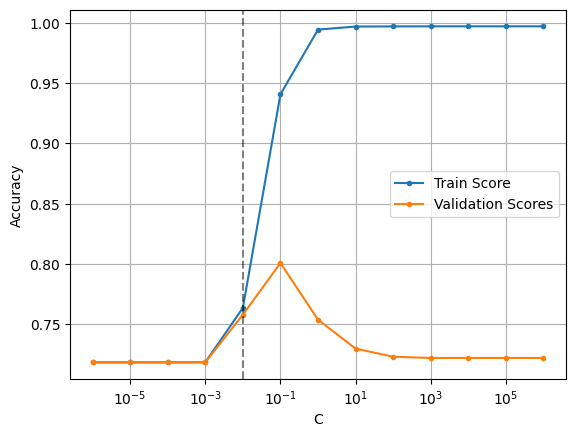

In [40]:
# Plotting results
C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

plt.figure()
plt.plot(C_range, all_train_scores_LR, label='Train Score', marker='.')
plt.plot(C_range, cross_validation_scores_LR, label='Validation Scores', marker='.')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.axvline(0.01, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

In [49]:
# At C = 10**-1
print(f'At C=10**-1\nTrain Score: {all_train_scores_LR[np.where(C_range==0.1)[0][0]]}\
    \nCross Validation Score: {cross_validation_scores_LR[np.where(C_range==0.1)[0][0]]}\n')
print(f'At C=10**-2\nTrain Score: {all_train_scores_LR[np.where(C_range==0.01)[0][0]]}\
    \nCross Validation Score: {cross_validation_scores_LR[np.where(C_range==0.01)[0][0]]}')

At C=10**-1
Train Score: 0.940792845405485    
Cross Validation Score: 0.8008825539718263

At C=10**-2
Train Score: 0.7636880939987948    
Cross Validation Score: 0.7580055013753438


Here, we can see that the highest validation accuracy is when $C=10^{-1}$. However, the model is severely overfitting with train score at 0.941 and validation score at 0.801. The closest point from $C=10^{-1}$ where train and validation gap is the least but still retains a good amount of accuracy is $C=10^{-2}$. Here the model gives us comparable poerformance with train score being 0.764 and validation score being 0.758.

Now we will fit the Logistic Regresion Model where $C=10^{-2}$ and $Penalty=L1$

In [46]:
# Optimized LR model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
X_remain_scaled = scaler.fit_transform(X_remain)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
LR = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=10000, random_state=1)
LR.fit(X_remain_scaled, y_remain)

# Scores
LR_train_score = LR.score(X_remain_scaled, y_remain)
LR_test_score = LR.score(X_test_scaled, y_test)

print(f'Train Score: {LR_train_score} \nTest Score: {LR_test_score}')

Train Score: 0.7835743801652892 
Test Score: 0.7985537190082644


The best logistic regression model is as follows:

| $C$ | Penalty                                 | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|-------|
| $10^{-1}$   | L1     | 0.758 | 0.784  | 0.799  |

## 2.2. <a id='toc2_2_'></a>[***Decision Tree***](#toc0_)

For Decision Tree, the initial hyperparemeter that we will be tuning is `max_depth` which is the maximum depth of the tree.

In [51]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# A list of max_depths for experimentation
depths = list(range(1, int(np.sqrt(len(X_remain)))))

cross_validation_scores_DT = {}
all_train_scores_DT = {}

for depth in depths:
    DT = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    # Train and cross validation scores
    scores = cross_validate(DT, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_DT[depth] = cv_score
    all_train_scores_DT[depth] = train_score

### 2.2.1. <a id='toc2_2_1_'></a>[***Best Hyperparameter (DT)***](#toc0_)

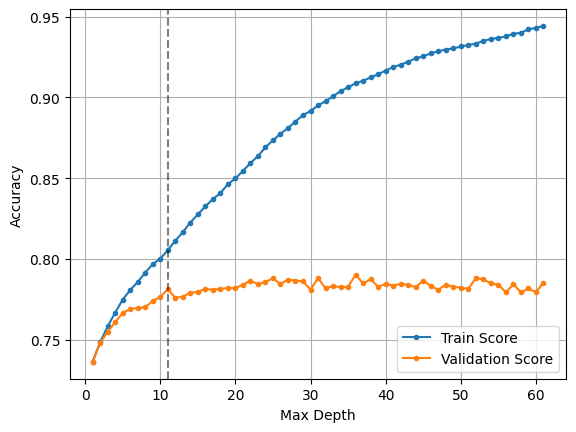

In [66]:
# Plotting results
depths = list(range(1, int(np.sqrt(len(X_remain)))))

plt.figure()
plt.plot(depths, all_train_scores_DT.values(), label="Train Score", marker=".")
plt.plot(depths, cross_validation_scores_DT.values(), label="Validation Score", marker=".")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.axvline(11, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the Decision Tree model, we can see that the Train Score continues to increase while the Validation Score reaches a plateau in which it oscilates over at around 0.78. This tells us that the model is overfitting the more we increase `max_depth`.

The `max_depth` that has a Validation Score that does not sacrifice accuracy while still being comparable to Train Score (not overfitting) would be 11. Any increase in `max_depth` will just continue to overfit to the training set with no gain in validation scores.

In [78]:
# Cross Validation Score
cross_validation_scores_DT[11]

0.7812509794115196

In [79]:
# Optimized DT Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Fitting the model
DT = DecisionTreeClassifier(max_depth=11, random_state=1)
DT.fit(X_remain, y_remain)

# Scores
DT_train_score = DT.score(X_remain, y_remain)
DT_test_score = DT.score(X_test, y_test)

print(f'Train Score: {DT_train_score} \nTest Score: {DT_test_score}')

Train Score: 0.8029442148760331 
Test Score: 0.8099173553719008


The best Decision Tree model is as follows:

| Max Depth | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 11   | 0.781 | 0.803  | 0.810   |

## 2.3. <a id='toc2_3_'></a>[***K-Nearest Neighbors***](#toc0_)

For KNN, the hyperparameter that we will be tuning is `n_neighbors` which is the number of neigbors to use in the algorithm. Note that the data is also scaled with `StandardScaler()` just like in Logistic Regression to ensure that larger features will not dominate the distance calculation in the algorithm.

In [65]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# A list of k_values to experiment on
k_values = list(range(1, 40))

cross_validation_scores_KNN = {}
all_train_scores_KNN = {}

for k in k_values:
    # Using a pipeline in order to scale the data at each fold
    KNN = Pipeline([("scaler", StandardScaler()),
                    ("model", KNeighborsClassifier(n_neighbors=k))])
    
    # Train and cross validation scores
    scores = cross_validate(KNN, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_KNN[k] = cv_score
    all_train_scores_KNN[k] = train_score

### 2.3.1. <a id='toc2_3_1_'></a>[***Best Hyperparameter (KNN)***](#toc0_)

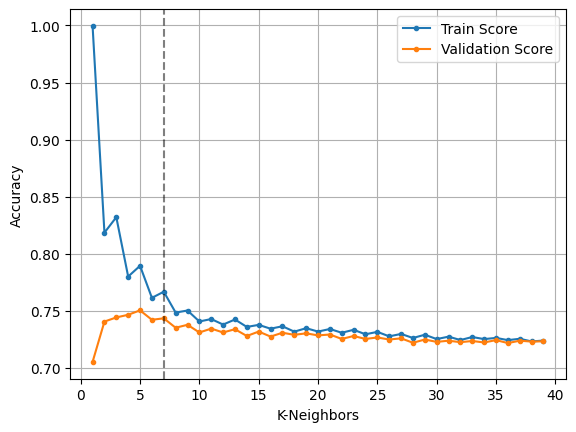

In [81]:
# Plotting results
k_values = list(range(1, 40))

plt.figure()
plt.plot(k_values, all_train_scores_KNN.values(), label="Train Score", marker=".")
plt.plot(k_values, cross_validation_scores_KNN.values(), label="Validation Score", marker=".")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.axvline(7, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the KNN model, we can see below that the Train Score decreases exponentially then tapers off to a plateau as we increase `K-Neighbors`. This is because initially, when `k = 1` each point is its own neighbor which the model memorizes and gets 100% accuracy on the Train set but does poorly on the Validation sets. As `k` increases, there are more neighbors that the model considers to make its predictions resulting in decreasing performance on the Train set and better performance for the Validation set (up to a certain point). The Validation scores peak when `k = 5` and decreases but in a slower fashion.

The `K-Neighbors` that has a Validation Score that doesn't not sacrifice overfitting while retaining decent accuracy would be 7. Any increase in `K-Neigbors` will decrease the Validation score albeit being closer to Train score.

In [82]:
# Cross Validation Score
cross_validation_scores_KNN[7]

0.7432821538718013

In [88]:
# Optimized KNN Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
X_remain_scaled = scaler.fit_transform(X_remain)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(X_remain_scaled, y_remain)

# Scores
KNN_train_score = KNN.score(X_remain_scaled, y_remain)
KNN_test_score = KNN.score(X_test_scaled, y_test)

print(f'Train Score: {KNN_train_score} \nTest Score: {KNN_test_score}')

Train Score: 0.7758264462809917 
Test Score: 0.7427685950413223


The best KNN model is as follows:

| K-Neighbours | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 7   | 0.743 | 0.776  | 0.743   |

## 2.4. <a id='toc2_4_'></a>[***Naïve Bayes***](#toc0_)

For Naïve Bayes, the hyperparameter that we will be tuning is the `alpha` which is the smoothing technique (Laplace Smoothing) that is applied in order to handle features (words in our case) with zero probabilities. The alpha is added to the counts of each feature and the probabilities of each word approach a uniform distribution as we increase `alpha`.

In [89]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

alpha_values = list(range(1, 20))

cross_validation_scores_NB = {}
all_train_scores_NB = {}

for alpha in alpha_values:
    NB = MultinomialNB(alpha=alpha)
    
    # Train and cross validation scores
    scores = cross_validate(NB, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_NB[alpha] = cv_score
    all_train_scores_NB[alpha] = train_score

### 2.4.1. <a id='toc2_4_1_'></a>[***Best Hyperparameter (NB)***](#toc0_)

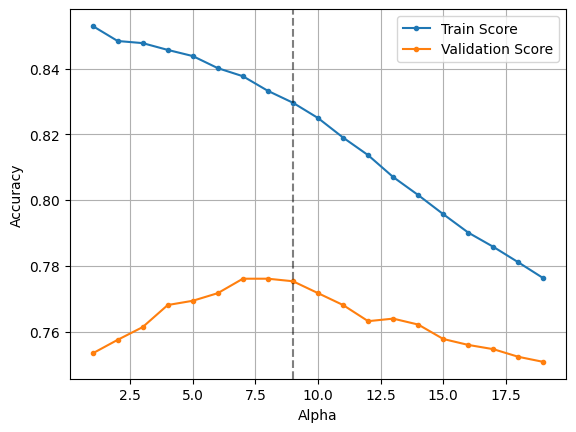

In [92]:
# Plotting results
alpha_values = list(range(1, 20))

plt.figure()
plt.plot(alpha_values, all_train_scores_NB.values(), label="Train Score", marker=".")
plt.plot(alpha_values, cross_validation_scores_NB.values(), label="Validation Score", marker=".")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.axvline(9, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the Naïve Bayes model, we can see below that the Train Score continually decreases as we increase `Alpha`. This is because the probabilities of words having a Negative/Neutral (0) or Positive (1) sentiment approaches 0.5 meaning that the model is less determinent (or confident) in its soft predictions. Therefore, as `Alpha` increases, the model is less able to fit the training data because of the increased smoothing.  

For Validation Score, at lower values of `Alpha`, the model is overfitting to the Train set which leads to poor performance in the Validation set. Validation Score increases from `Alpha = 1` to `Alpha = 7` and then decreases thereafter. This tells us that the model generalizes best on unseen data at around `Alpha = 7`. 

The model that best captures the Bias and Variance trade-off is at `Alpha = 9`. Although we are losing ***some*** Validation accuracy compared to `Alpha = 7` the gap between Validation and Train score at `Alpha = 9` is much lower compared to `Alpha = 7` so this will be the best hyperparameter setting for Naïve Bayes.

**Note** that the model is very much overfitting regardless.

In [97]:
# Cross Validation Score
cross_validation_scores_NB[9]

0.7753108277069266

In [98]:
# Optimized NB Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Fitting the model
NB = MultinomialNB(alpha=9)
NB.fit(X_remain, y_remain)

# Scores
NB_train_score = NB.score(X_remain, y_remain)
NB_test_score = NB.score(X_test, y_test)

print(f"Train Score: {NB_train_score} \nTest Score: {NB_test_score}")

Train Score: 0.8267045454545454 
Test Score: 0.7840909090909091


The best Naïve Bayes model is as follows:

| Alpha | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 9   | 0.775 | 0.827  | 0.784   |

## 2.5. <a id='toc2_5_'></a>[**Comparing all base models**](#toc0_)

**Logistic Regression**:

| $C$ | Penalty                                 | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|-------|
| $10^{-1}$   | L1     | 0.758 | 0.784  | 0.799  |

**Decision Tree**:

| Max Depth | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 11   | 0.781 | 0.803  | 0.810   |

**KNN**:

| K-Neighbours | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 7   | 0.743 | 0.776  | 0.743   |

**Naïve-Bayes**:

| Alpha | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 9   | 0.775 | 0.827  | 0.784   |

Based on the first pass of hyperparameter tuning of all the models, the ***Decision Tree*** model has the highest accuracy in the Test Set. However, since our data is **imbalanced** in favour of Class 0 (Negative/Neutral), this is actually misleading. The next [section](#model-evaluation) explores how these models compare in identifying the positive class which is the class that is also crucial to us as a positive sentiment may lead to higher stock prices.

# 3. <a id='toc3_'></a>[**Model Evaluation**](#toc0_)

This section explores all the base models' performance in identifying Class 0 (Negative/Neutral) and Class 1 (Positive).

## 3.1. <a id='toc3_1_'></a>[***Logistic Regression***](#toc0_)

### 3.1.1. <a id='toc3_1_1_'></a>[***Confusion Matrix***](#toc0_)

Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression Model')

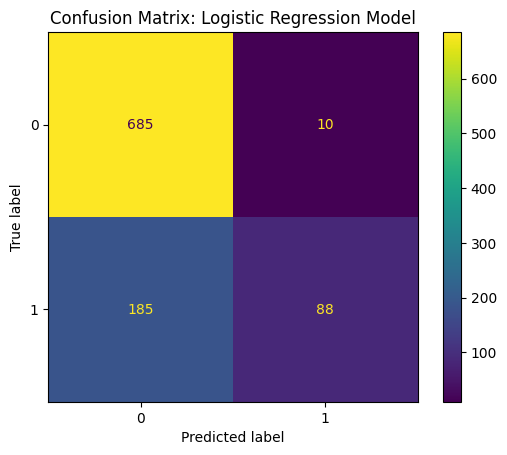

In [153]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_remain)
X_test_scaled = scaler.transform(X_test)

ConfusionMatrixDisplay.from_estimator(LR, X_test_scaled, y_test) # Using scaled data for Logistic Regression
plt.title('Confusion Matrix: Logistic Regression Model')

Evidently, we can see the the dataset's imbalance of 72% `Class 0` to 28% `Class 1` most likely contributes to the model's ability to perform much better in identifying True Negatives (685) than True Positives (88). Consequently, there are more False Negatives identified by the model at 185 than False Positives identified by the model at 10.

### 3.1.2. <a id='toc3_1_2_'></a>[***Classification Report***](#toc0_)

In [154]:
# Classification Report
from sklearn.metrics import classification_report

y_pred_LR = LR.predict(X_test_scaled)

report_LR = classification_report(y_test, y_pred_LR)
print(report_LR)

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       695
           1       0.90      0.32      0.47       273

    accuracy                           0.80       968
   macro avg       0.84      0.65      0.67       968
weighted avg       0.82      0.80      0.76       968



The model performs well with `Class 0` (Negative/Neutral) with a high `Recall` at 0.99 and decent `Precision` at 0.79 which gives us the `F1-Score` of 0.88. However, because our data is imbalanced in favour of `Class 0` (72%), our model is more likely to be ***overfitting***. 

This is further proven by the low `Recall` of the positive class at 0.32 which tells us that the model misses a good amount of `Class 1` by classifying them as `Class 0`. Although `Precision` in `Class 1` gives us a great score at 0.90, the `F1-Score` leaves more to be desired and therefore can be improved.

This story is similar for all the 4 base models with slight differences.

### 3.1.3. <a id='toc3_1_3_'></a>[***ROC and PR Curve***](#toc0_)

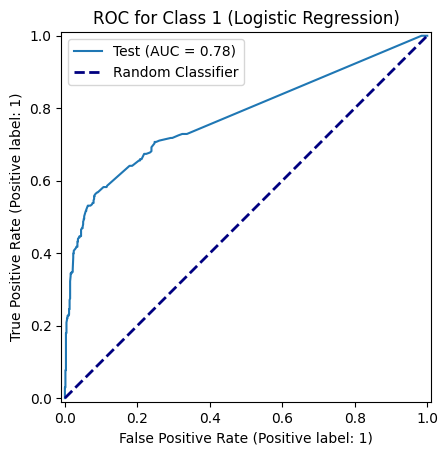

In [155]:
from sklearn.metrics import RocCurveDisplay

# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(LR, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (Logistic Regression)')
plt.show()

The plot is the ROC Curve for `Class 1` which is the minority class. The ROC Curve can look misleading as it can look decent via the `AUC` of 0.78 (it is definitely better than the random classifier). However, from the low Recall of `Class 1` at (0.32), we know that the Logistic Regression model misclassifies a decent amount of `Class 1`. In that same token, the curve tells us that we can actually increase Recall (True Positive Rate) while maintaining a relatively low False Positive Rate (FPR) due to a steep slope near the y-axis.

A better visual to look at is the ***Precision-Recall (PR) Curve*** and its AUC (AP) since our data is imbalanced. Below is an illustration:

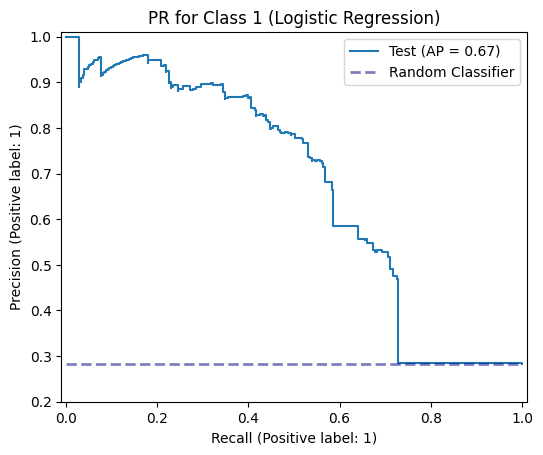

In [168]:
from sklearn.metrics import PrecisionRecallDisplay

baseline = (sum(y_test) / len(y_test))

# PR Curve
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(LR, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (Logistic Regression)')
plt.show()

The PR curve gives us a better look at the trade-off between `Precision` and `Recall`. The Random Classifier line indicated the Precision if a Random Classifier was used. This line is equal to the proportion of our dataset that is in `Class 1` meaning that a Random Classifier's expected `Precision` is the same as the proportion of `Class 1` (no predictive power).

In this curve, we see `Precision` initially being high at lower thresholds and quickly drops as `Recall` is increased. The imbalance dataset has created a steep downward slope of the PR curve indicating the presense of more `False Positives` as we increase `Recall` thus a quickly decreasing `Precision`. The `AP` is the ***area under the curve** (**AUC-PR**) of the PR curve. It tells us the average `Precision` across different values of `Recall`. 0.67 is modest considering the imbalance nature of the dataset.

## 3.2. <a id='toc3_2_'></a>[***Decision Tree***](#toc0_)

### 3.2.1. <a id='toc3_2_1_'></a>[***Confusion Matrix***](#toc0_)

Text(0.5, 1.0, 'Confusion Matrix: Decision Tree Model')

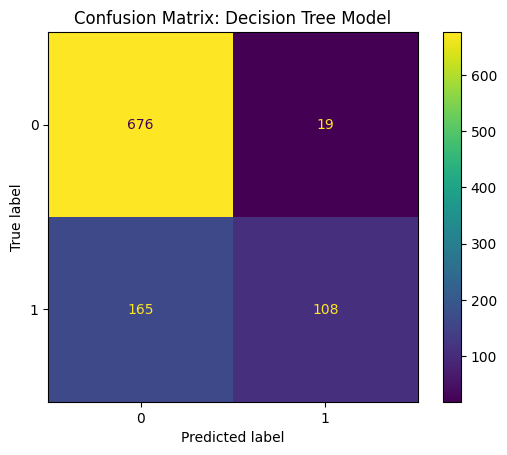

In [157]:
# Confusion Matrix

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

ConfusionMatrixDisplay.from_estimator(DT, X_test, y_test)
plt.title('Confusion Matrix: Decision Tree Model')

The Decision Tree model seems to do a better job of identifying `True Positves` at 108 versus 88 for Logistic Regression. This is of course at the cost of more `False Positives` at 19 versus 10 for Logistic Regression.

### 3.2.2. <a id='toc3_2_2_'></a>[***Classification Report***](#toc0_)

In [158]:
# Classification Report
y_pred_DT = DT.predict(X_test)

report_DT = classification_report(y_test, y_pred_DT)
print(report_DT)

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       695
           1       0.85      0.40      0.54       273

    accuracy                           0.81       968
   macro avg       0.83      0.68      0.71       968
weighted avg       0.82      0.81      0.78       968



Compared to Logistic Regression, Decision Tree does a better job of classifiying for `Class 1` with `Recall` at 0.40 which is a step in the right direction. However, it still does poorly in comparison to more balanced datasets. There is also an improvement in `F1-Score` at 0.54.

### 3.2.3. <a id='toc3_2_3_'></a>[***ROC and PR Curve***](#toc0_)

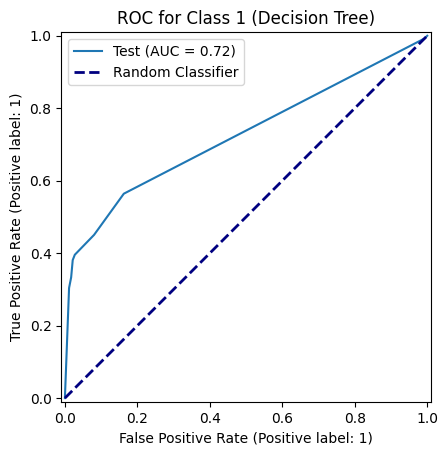

In [159]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(DT, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (Decision Tree)')
plt.show()

The ROC Curve for Decision Tree is quite similar to Logistic Regression in its shape. A big difference is the `AUC` being at 0.72 compared to 0.78 for Logistic Regression. Logistic Regression is said to distinguish between classes better than Decision Tree but as previously mentioned, this is misleading due to the imbalance nature of the dataset.

Again, below is the ***PR curve*** for further analysis:

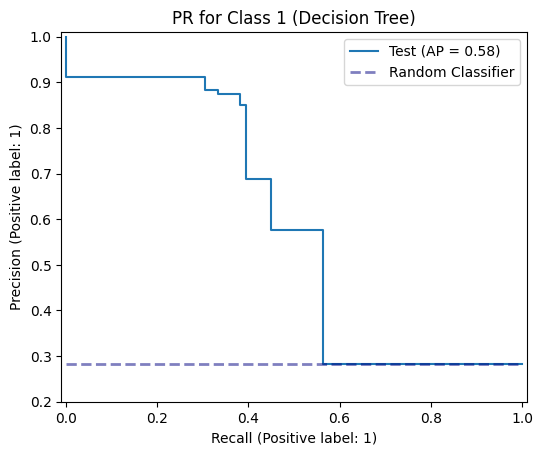

In [178]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(DT, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (Decision Tree)')
plt.show()

Compared to Logistic Regression, the `AP` for Decision Tree is less at 0.58. This makes sense as `Precision` for `Class 1` is lower at 0.85 than 0.90 for Logistic regression. In addition, the drop off in `Precision` is also greater in Decision Tree.

It is important to note that `Precision` is the same as the baseline Random Classifier at lower levels of `Recall` compared to Logistic Regression. For example, in Decision Tree, baseline `Precision` is reached at just before 0.6 `Recall` whereas baseline is reached at just over 0.7 `Recall` in Logistic Regression. Logistic Regression preserves its `Precision` much better.

## 3.3. <a id='toc3_3_'></a>[***KNN***](#toc0_)

### 3.3.1. <a id='toc3_3_1_'></a>[***Confusion Matrix***](#toc0_)

Text(0.5, 1.0, 'Confusion Matrix: KNN Model')

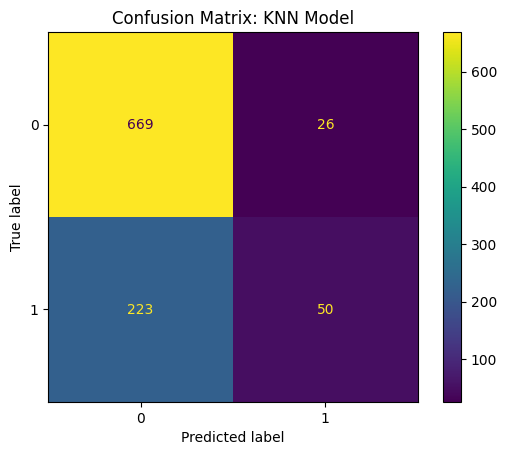

In [114]:
# Confusion Matrix

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_remain)
X_test_scaled = scaler.transform(X_test)

ConfusionMatrixDisplay.from_estimator(KNN, X_test_scaled, y_test)
plt.title('Confusion Matrix: KNN Model')

We can see that KNN does a poor job of identifying `Class 1` than both Decision Tree and Logistic Regression. This is seen by its much lower `True Positive` count at 50 and `False Positive` count at 26. Notice the higher amount of `False Negatives` compared to the previous two models at 223.

### 3.3.2. <a id='toc3_3_2_'></a>[***Classification Report***](#toc0_)

In [115]:
# Classification Report

y_pred_KNN = KNN.predict(X_test_scaled)

report_KNN = classification_report(y_test, y_pred_KNN)
print(report_KNN)

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       695
           1       0.66      0.18      0.29       273

    accuracy                           0.74       968
   macro avg       0.70      0.57      0.56       968
weighted avg       0.72      0.74      0.69       968



KNN does the worst job so far in `Class 1` performance. Its `Recall` being the lowest at 0.18, `Precision` at 0.66, resulting in a low `F1-Score` of 0.29.

### 3.3.3. <a id='toc3_3_3_'></a>[***ROC and PR Curve***](#toc0_)

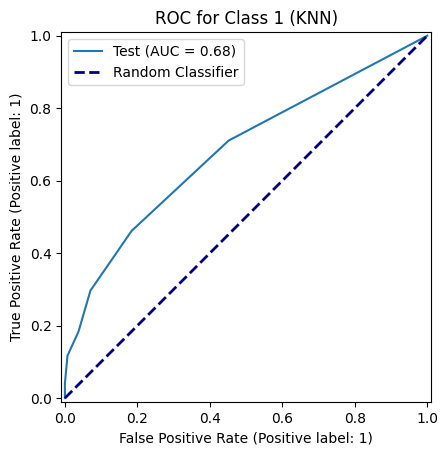

In [139]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(KNN, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (KNN)')
plt.show()

As expected, KNN has the lower `AUC` of 0.68. It has the worse performance in distinguishing classes compared to Decision Tree and Logistic Regression.

Below is the ***PR Curve*** for comparison:

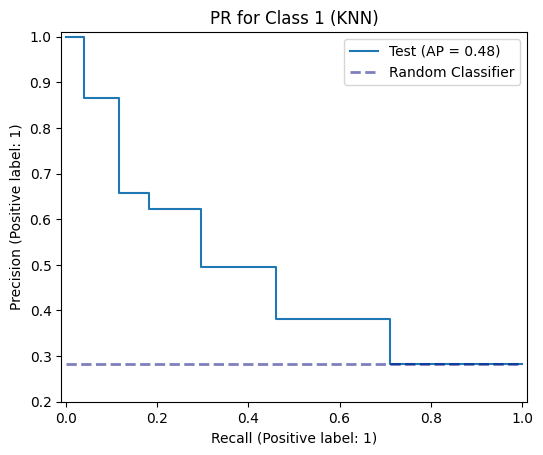

In [171]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(KNN, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (KNN)')
plt.show()

As expected, the `AP` for KNN is the lowest so far at 0.48.

There is a distinct change in curvature in the PR curve compared to the previous two models. The PR curve does not kink outward to the right but is rather closer to the origin. 

This may indicate that the KNN model struggles with `Precision` as we introduce higher levels of `Recall`. 

In other words, as the model tries to identify more of the positive class, much more `False Positives` are classified compared to the previous two models making KNN a weaker model.



## 3.4. <a id='toc3_4_'></a>[***Naïve Bayes***](#toc0_)

### 3.4.1. <a id='toc3_4_1_'></a>[***Confusion Matrix***](#toc0_)

Text(0.5, 1.0, 'Confusion Matrix: Naïve Bayes Model')

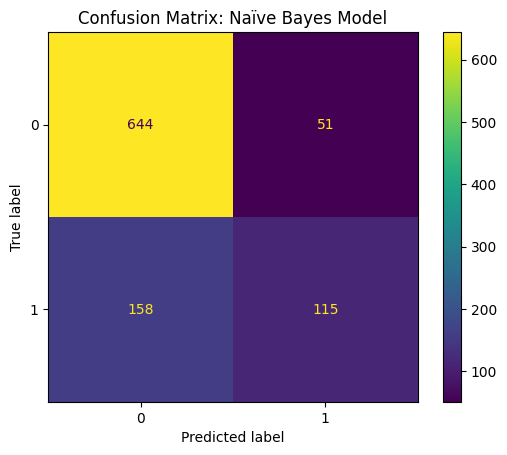

In [142]:
# Confusion Matrix

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

ConfusionMatrixDisplay.from_estimator(NB, X_test, y_test)
plt.title('Confusion Matrix: Naïve Bayes Model')

Naïve Bayes does the best job in classifying `True Positives` at 115 compared to the previous 3 models. It also has the most `False Positives` at 51 which is to be expected for a model that classifies more Positive instances. Consequently, `False Negatives` are the lowest in Naïve Bayes as 158 and `True Negatives` at 644.

### 3.4.2. <a id='toc3_4_2_'></a>[***Classification Report***](#toc0_)

In [143]:
# Classification Report
y_pred_NB = NB.predict(X_test)

report_NB = classification_report(y_test, y_pred_NB)
print(report_NB)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       695
           1       0.69      0.42      0.52       273

    accuracy                           0.78       968
   macro avg       0.75      0.67      0.69       968
weighted avg       0.77      0.78      0.77       968



`Recall` is the highest amongst all four base models at 0.42 for Class 1. This is at the cost of a lower `Precision` at 0.69 compared to Decision Tree (0.85) and Logistic Regression (0.90) which leads to an `F1-Score` of 0.52 (second to Decision Tree).

### 3.4.3. <a id='toc3_4_3_'></a>[***ROC Curve***](#toc0_)

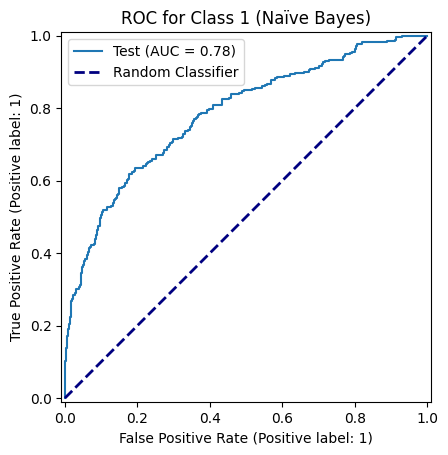

In [173]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(NB, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (Naïve Bayes)')
plt.show()

First thing to notice that the `AUC` for Naïve Bayes is the same for Logistic Regression with just varying curvature of the ROC Curve. In comparison to Logistic Regression, Naïve Bayes provides a more balanced approach to classification with its ability to better classify `Class 1` (at the expense of a higher `False Positive Rate`).

Below is the ***PR Curve*** for comparison:

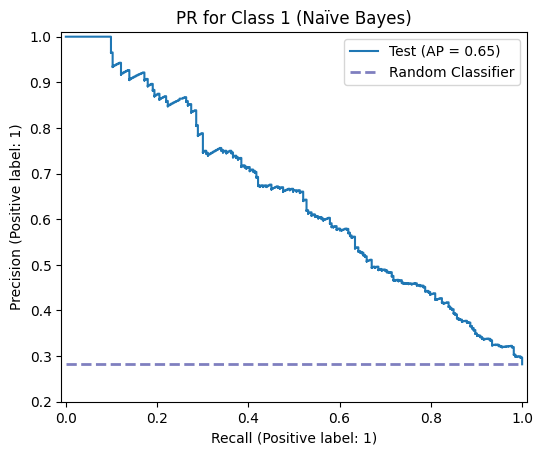

In [176]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots()
PrecisionRecallDisplay.from_estimator(NB, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (Naïve Bayes)')
plt.show()

The first thing to notice is how perfect `Precision` is maintained at lower levels of `Recall` (e.g. from 0 to 0.1). The decline of `Precision` is much more gradual compared to the rest of the models which indicates stability of the model across various levels of `Recall`. The `AP` is also the second highest at 0.65. A combination of stability and higher Average Precision might give us a more reliable model.

Unlike All the other models, Naïve Bayes seems to stay above the Random Classifier baseline of `Precision` for most levels of `Recall`.

## 3.5. <a id='toc3_5_'></a>[***Insights***](#toc0_)

- All four base models struggle in `Class 1` performance.
- Knowing that Positive Sentiment is important for sentiment analysis, Naïve Bayes is the best model as it has the best `Recall` for `Class 1` while giving us a consistent `Precision` at all levels of `Recall`.
- Decision Tree provides a more balanced approach in classifying `Class 1` with the highest `F1-Score` and a modest `AP`.
- Logistic Regression performs well in `Class 1` `Precision` (also indicated by the highest `AP`) but there is a big tradeoff with `Recall` indicated by a steep slope in its PR Curve.
- KNN performed the worst out of all four models when it comes to classifying `Class 1` and having the lowest `AP`.

# 4. <a id='toc4_'></a>[**Dealing with Imbalanced Data**](#toc0_)

This section will outline how we will deal with the imbalance data. We will look at an upsampling approach called ***SMOTE***.

## 4.1. <a id='toc4_1_'></a>[***SMOTE***](#toc0_)

SMOTE (Synthetic Minority Oversampling TEchnique) is a upsampling method in which synthetic data is created from the minority class. We will explore it below.

Recall our dataset:

In [192]:
# Extracting columns
X = df['Headline']
y = df['Sentiment']

# Vectorizing
bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer, ngram_range=(1, 1))

# Fitting
bagofwords.fit(X)
X_bow = bagofwords.transform(X)

X_bow = pd.DataFrame(data=X_bow.toarray(), columns=bagofwords.get_feature_names_out())

X_bow

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000,021,050,100,1000,10000,100000,105,110,112,...,yard,year,yearonyear,yesterday,yet,yit,york,zinc,zone,àland
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [193]:
# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

In [194]:
# Instantiating SMOTE sampler
smote = SMOTE(random_state=1) # Random state for reproducibility

# Fitting the remain data:
X_remain_sm, y_remain_sm = smote.fit_resample(X_remain, y_remain)

In [195]:
# Checking distribution
print('Original class distribution')
display(pd.Series(y_remain).value_counts().sort_index(),
        pd.Series(y_remain).value_counts(normalize=True).sort_index())

print('\nResampled class distribution')
display(pd.Series(y_remain_sm).value_counts().sort_index(),
        pd.Series(y_remain_sm).value_counts(normalize=True).sort_index())

Original class distribution


Sentiment
0    2782
1    1090
Name: count, dtype: int64

Sentiment
0    0.718492
1    0.281508
Name: proportion, dtype: float64


Resampled class distribution


Sentiment
0    2782
1    2782
Name: count, dtype: int64

Sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

Comparing the resampled dataset with the original, SMOTE increased the number of `Class 1` to the same amount as `Class 0` creating a balanced dataset.

Now we will use the upsampled dataset on the four base models with the optimized hyperparameters from earlier

### 4.1.1. <a id='toc4_1_1_'></a>[***Logistic Regression***](#toc0_)

Where $C=10^{-2}$ and $Penalty=L1$

In [197]:
# Scale data
scaler = StandardScaler()
X_remain_sm_scaled = scaler.fit_transform(X_remain_sm)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
LR_sm = LogisticRegression(solver='liblinear', penalty='l1',
                           C=0.01, random_state=1,
                           max_iter=10000, n_jobs=-1)
LR_sm.fit(X_remain_sm_scaled, y_remain_sm)

# Scores
LR_sm_train_score = LR_sm.score(X_remain_sm_scaled, y_remain_sm)
LR_sm_test_score = LR_sm.score(X_test_scaled, y_test)

print(f'Train Score: {LR_sm_train_score} \nTest Score: {LR_sm_test_score}')

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Train Score: 0.7757009345794392 
Test Score: 0.6291322314049587


Comparing both models:

|     | Train Score    | Test Score    |
|-------|-------|-------|
| **LogReg on Unsampled Data** | 0.784  | 0.799  |
| **LogReg on SMOTE-sampled Data** | 0.776  | 0.629  |


The performance of the model in the Test set seemed to have decreased significantly while the Train score decreased slightly.

#### 4.1.1.1. <a id='toc4_1_1_1_'></a>[***Evaluation***](#toc0_)

##### 4.1.1.1.1. <a id='toc4_1_1_1_1_'></a>[***Confusion Matrix and Classification Report***](#toc0_)

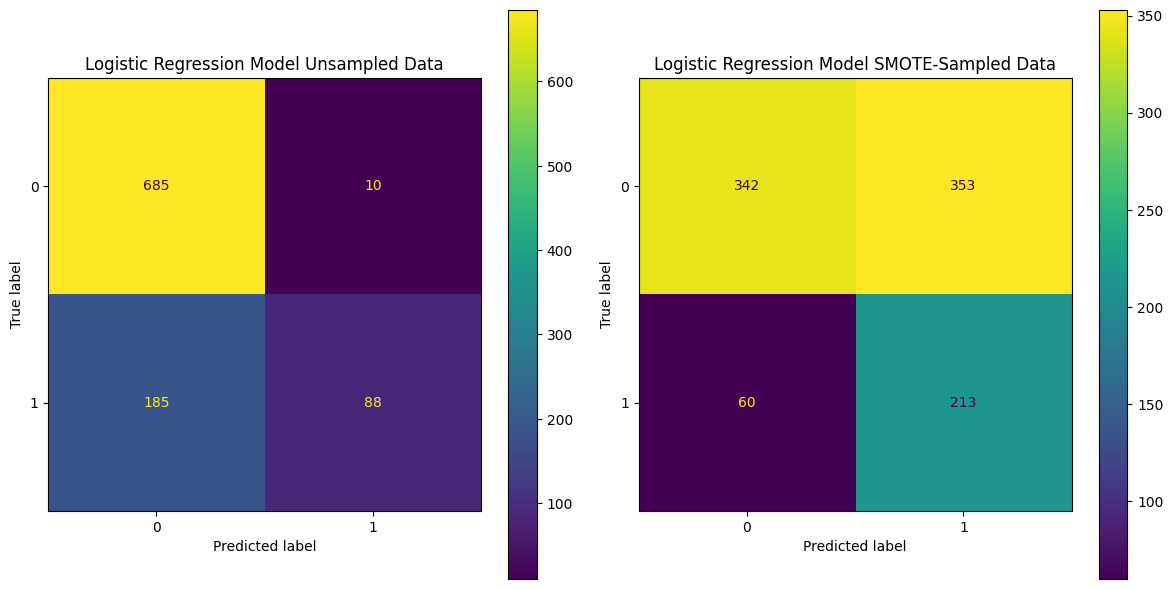

In [229]:
# Scale the unsampled data
scaler = StandardScaler()
scaler.fit(X_remain)
X_test_scaled = scaler.transform(X_test)

# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(LR, X_test_scaled, y_test, ax=ax[0]) # Using scaled data for Logistic Regression
plt.title('Logistic Regression Model Unsampled Data')
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(LR_sm, X_test_scaled, y_test, ax=ax[1]) # Using scaled data for Logistic Regression
plt.title('Logistic Regression Model SMOTE-Sampled Data')

plt.tight_layout()
plt.show()

In [217]:
# Classification Report
y_pred_LR = LR.predict(X_test_scaled)

report_LR = classification_report(y_test, y_pred_LR)
print('LR on Unsampled Data Classification Report')
print(report_LR)

y_pred_LR_sm = LR_sm.predict(X_test_scaled)
report_LR_sm = classification_report(y_test, y_pred_LR_sm)
print('\nLR on SMOTE-Sampled Data Classification Report')
print(report_LR_sm)

LR on Unsampled Data Classification Report
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       695
           1       0.90      0.32      0.47       273

    accuracy                           0.80       968
   macro avg       0.84      0.65      0.67       968
weighted avg       0.82      0.80      0.76       968


LR on SMOTE-Sampled Data Classification Report
              precision    recall  f1-score   support

           0       0.85      0.49      0.62       695
           1       0.38      0.78      0.51       273

    accuracy                           0.57       968
   macro avg       0.61      0.64      0.57       968
weighted avg       0.72      0.57      0.59       968



When looking at both the confusion matrices and the Classification reports, it is clear to see that performance has now increased in `Class 1`. The addition of SMOTE improved `Recall` for `Class 1` but at the expense of `Precision`. `Recall` significantly dropped (50% decrease) for `Class 0` which brings down the overall performance of the model.

##### 4.1.1.1.2. <a id='toc4_1_1_1_2_'></a>[***ROC and PR Curve***](#toc0_)

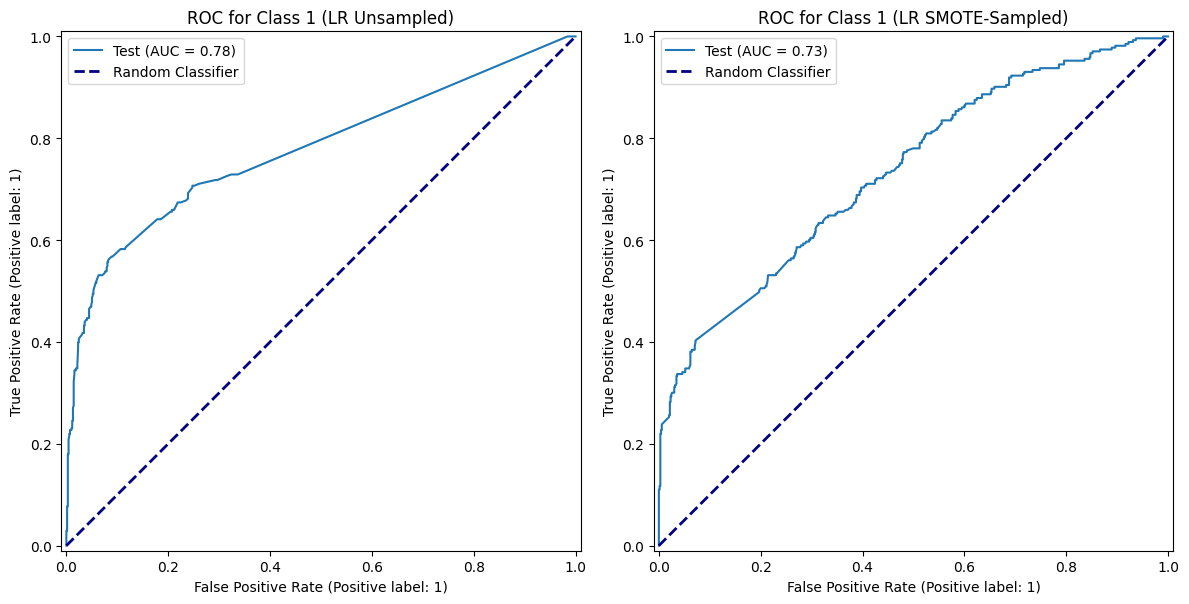

In [233]:
# ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(LR, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (LR Unsampled)')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(LR_sm, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (LR SMOTE-Sampled)')
plt.tight_layout()
plt.show()

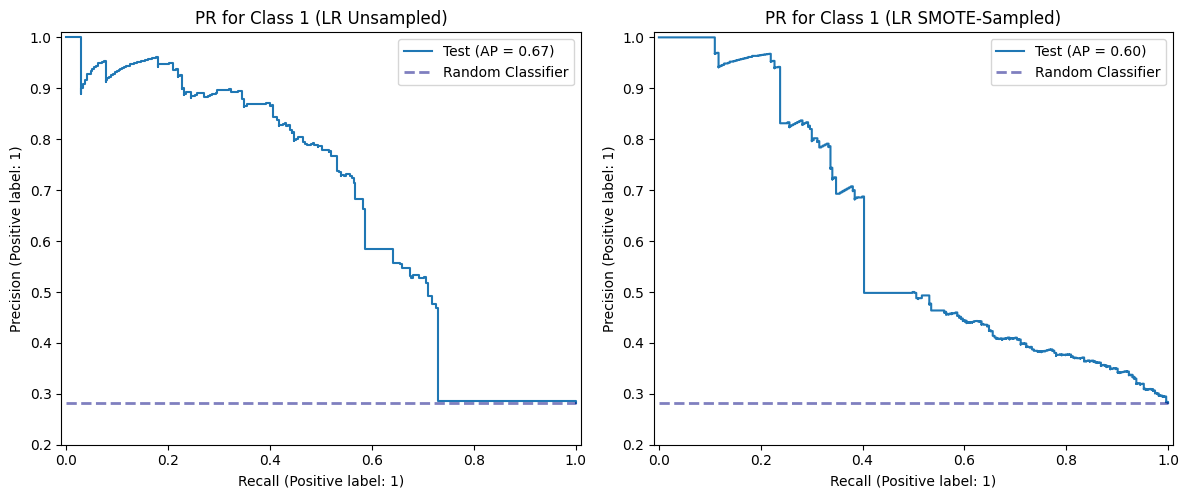

In [225]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(LR, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (LR Unsampled)')

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(LR_sm, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (LR SMOTE-Sampled)')
plt.tight_layout()
plt.show()

Introducting SMOTE decreased the `AUC-ROC` to `0.73` which is a modest decline. The same can be said for the `AUC-PR` decreasing to `0.60` which indicates that the Average Precision as decreased. The second PR Curve looks to be above the the Random Classifier for most `Recall` values which may indicate more of a "stability" in classifying `Class 1`.

Overall, it does look like performance has decreased when SMOTE is applied. We have gone the opposite way (better `Class 1` performance at the expense of `Class 0`)

### 4.1.2. <a id='toc4_1_2_'></a>[***Decision Tree***](#toc0_)

Where `max_depth` = 11

In [228]:
# Fitting the model
DT_sm = DecisionTreeClassifier(max_depth=11, random_state=1)
DT_sm.fit(X_remain_sm, y_remain_sm)

# Scores
DT_sm_train_score = DT_sm.score(X_remain_sm, y_remain_sm)
DT_sm_test_score = DT_sm.score(X_test, y_test)

print(f'Train Score: {DT_sm_train_score} \nTest Score: {DT_sm_test_score}')

Train Score: 0.6241912293314162 
Test Score: 0.41735537190082644


Comparing both models:

|     | Train Score    | Test Score    |
|-------|-------|-------|
| **Decision Tree on Unsampled Data** | 0.803  | 0.810  |
| **Decision Tree on SMOTE-sampled Data** | 0.624  | 0.417  |

Continuing with the same theme, performance has also decreased in Decision Tree when SMOTE is introduced on both Train and Test sets.

#### 4.1.2.1. <a id='toc4_1_2_1_'></a>[***Evaluation***](#toc0_)

##### 4.1.2.1.1. <a id='toc4_1_2_1_1_'></a>[***Confusion Matrix and Classification Report***](#toc0_)

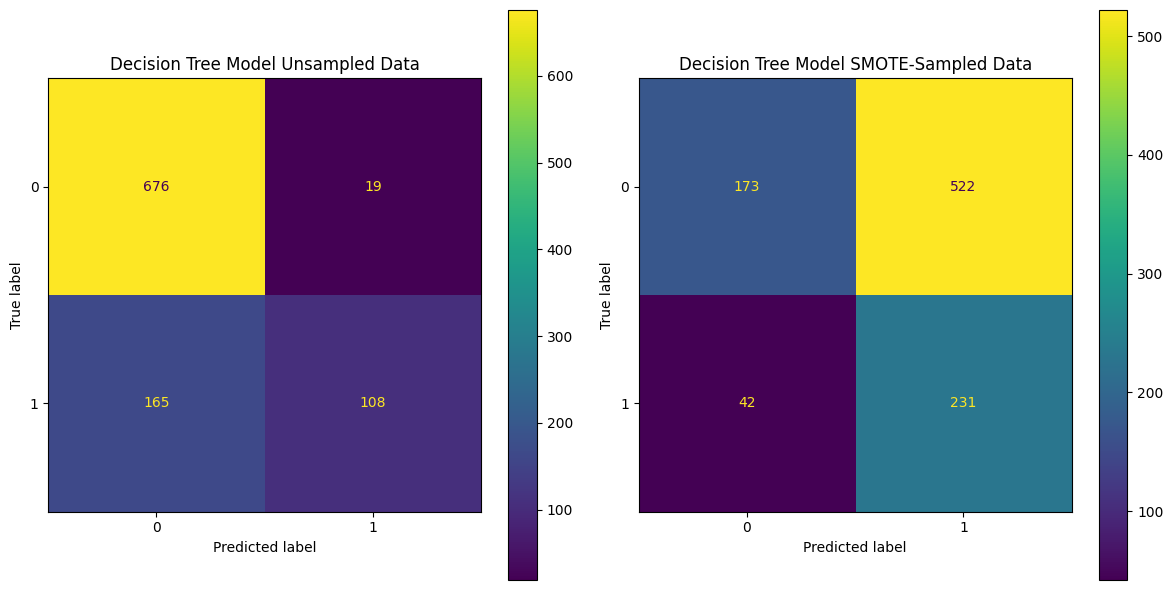

In [234]:
# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(DT, X_test, y_test, ax=ax[0]) # Using scaled data for Logistic Regression
plt.title('Decision Tree Model Unsampled Data')
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(DT_sm, X_test, y_test, ax=ax[1]) # Using scaled data for Logistic Regression
plt.title('Decision Tree Model SMOTE-Sampled Data')

plt.tight_layout()
plt.show()

In [235]:
# Classification Report
y_pred_DT = DT.predict(X_test)
report_DT = classification_report(y_test, y_pred_DT)
print('DT on Unsampled Data Classification Report')
print(report_DT)

y_pred_DT_sm = DT_sm.predict(X_test)
report_DT_sm = classification_report(y_test, y_pred_DT_sm)
print('\nDT on SMOTE-Sampled Data Classification Report')
print(report_DT_sm)

DT on Unsampled Data Classification Report
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       695
           1       0.85      0.40      0.54       273

    accuracy                           0.81       968
   macro avg       0.83      0.68      0.71       968
weighted avg       0.82      0.81      0.78       968


DT on SMOTE-Sampled Data Classification Report
              precision    recall  f1-score   support

           0       0.80      0.25      0.38       695
           1       0.31      0.85      0.45       273

    accuracy                           0.42       968
   macro avg       0.56      0.55      0.42       968
weighted avg       0.66      0.42      0.40       968



`Recall` has increased significantly for `Class 1` but at the expense of `Precision` in `Class 1` and `Recall` in `Class 0`

##### 4.1.2.1.2. <a id='toc4_1_2_1_2_'></a>[***ROC and PR Curve***](#toc0_)

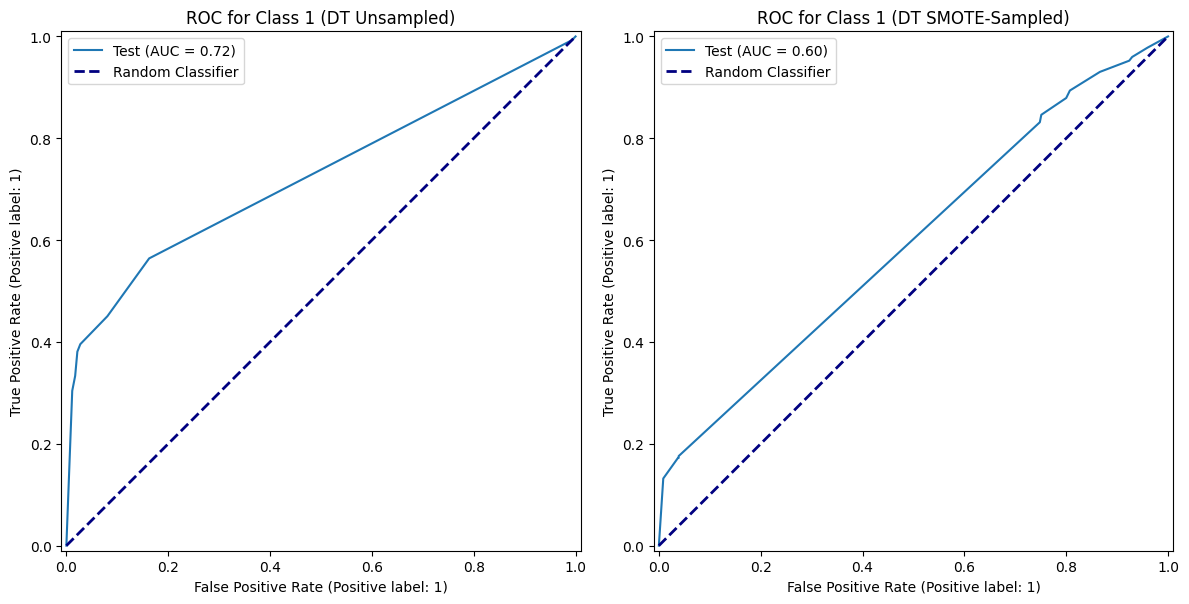

In [236]:
# ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(DT, X_test, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (DT Unsampled)')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(DT_sm, X_test, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (DT SMOTE-Sampled)')
plt.tight_layout()
plt.show()

`AUC` decreased from 0.72 to 0.60 indicating lower performance at all thresholds

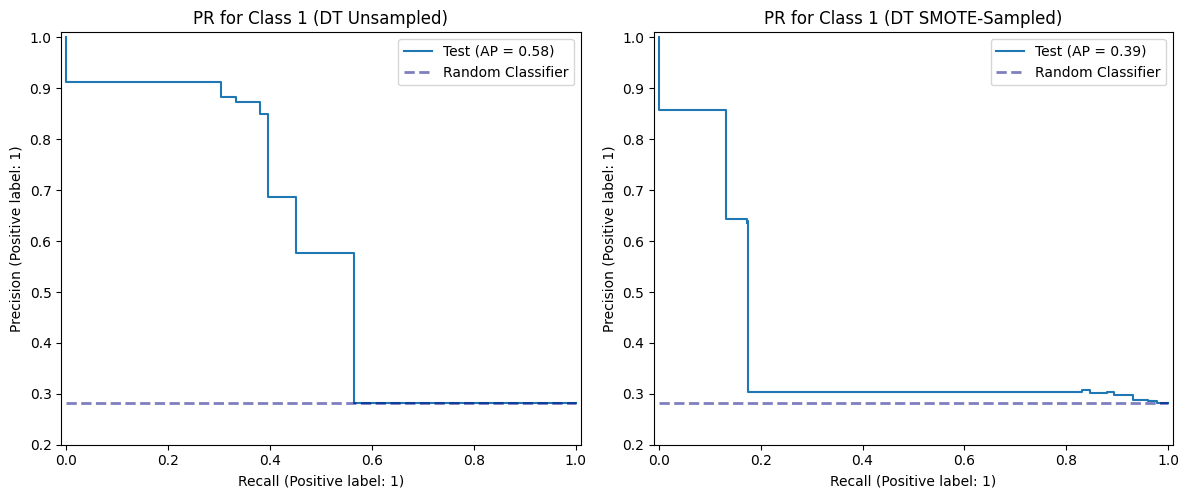

In [238]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(DT, X_test, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (DT Unsampled)')

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(DT_sm, X_test, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (DT SMOTE-Sampled)')
plt.tight_layout()
plt.show()

`AP` decreased from 0.58 to 0.39 when SMOTE is applied.

### 4.1.3. <a id='toc4_1_3_'></a>[***KNN***](#toc0_)

Where `K-Neighbors` = 11

In [241]:
# Scale data
scaler = StandardScaler()
X_remain_sm_scaled = scaler.fit_transform(X_remain_sm)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
KNN_sm = KNeighborsClassifier(n_neighbors=7)
KNN_sm.fit(X_remain_sm_scaled, y_remain_sm)

# Scores
KNN_sm_train_score = KNN_sm.score(X_remain_sm_scaled, y_remain_sm)
KNN_sm_test_score = KNN_sm.score(X_test_scaled, y_test)

print(f'Train Score: {KNN_sm_train_score} \nTest Score: {KNN_sm_test_score}')

Train Score: 0.6008267433501079 
Test Score: 0.5475206611570248


Comparing both models:

|     | Train Score    | Test Score    |
|-------|-------|-------|
| **KNN on Unsampled Data** | 0.776  | 0.743  |
| **KNN on SMOTE-sampled Data** | 0.601  | 0.548  |

Once again performance has dramatically decreased when SMOTE is applied.

#### 4.1.3.1. <a id='toc4_1_3_1_'></a>[***Evaluation***](#toc0_)

##### 4.1.3.1.1. <a id='toc4_1_3_1_1_'></a>[***Confusion Matrix and Classification Report***](#toc0_)

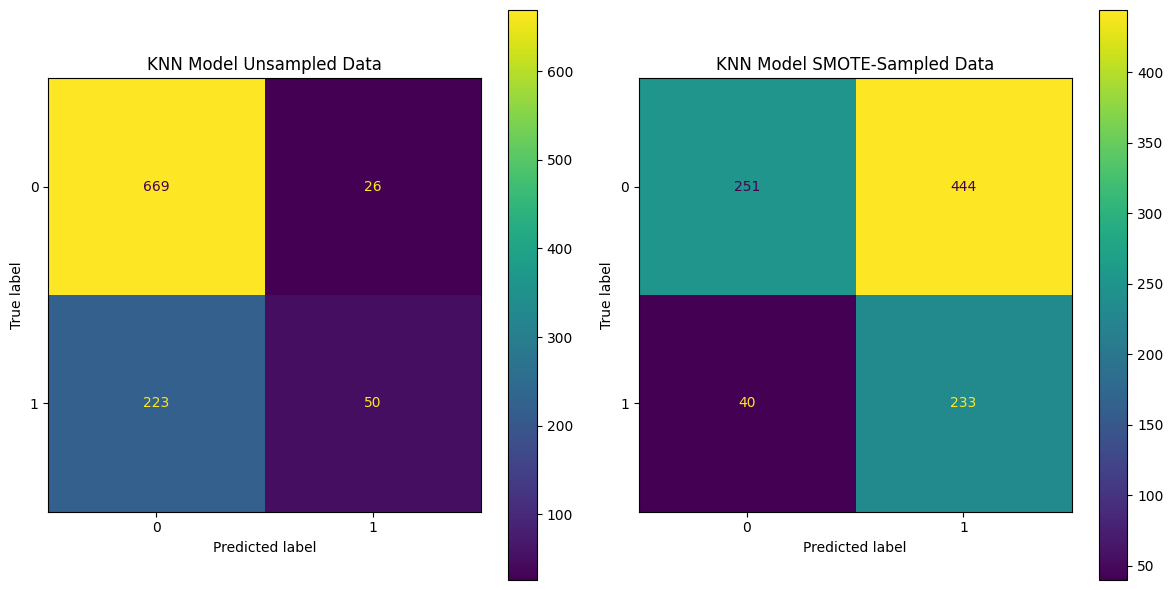

In [242]:
# Scale the unsampled data
scaler = StandardScaler()
scaler.fit(X_remain)
X_test_scaled = scaler.transform(X_test)

# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(KNN, X_test_scaled, y_test, ax=ax[0]) # Using scaled data for Logistic Regression
plt.title('KNN Model Unsampled Data')
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(KNN_sm, X_test_scaled, y_test, ax=ax[1]) # Using scaled data for Logistic Regression
plt.title('KNN Model SMOTE-Sampled Data')

plt.tight_layout()
plt.show()

We see significant improvement in True Positive predictions as the cost of greater False Positives.

In [244]:
# Classification Report
y_pred_KNN = KNN.predict(X_test_scaled)
report_KNN = classification_report(y_test, y_pred_KNN)
print('KNN on Unsampled Data Classification Report')
print(report_KNN)

y_pred_KNN_sm = KNN_sm.predict(X_test_scaled)
report_KNN_sm = classification_report(y_test, y_pred_KNN_sm)
print('\nKNN on SMOTE-Sampled Data Classification Report')
print(report_KNN_sm)

KNN on Unsampled Data Classification Report
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       695
           1       0.66      0.18      0.29       273

    accuracy                           0.74       968
   macro avg       0.70      0.57      0.56       968
weighted avg       0.72      0.74      0.69       968


KNN on SMOTE-Sampled Data Classification Report
              precision    recall  f1-score   support

           0       0.86      0.36      0.51       695
           1       0.34      0.85      0.49       273

    accuracy                           0.50       968
   macro avg       0.60      0.61      0.50       968
weighted avg       0.72      0.50      0.50       968



Same story as the other models, `Recall` is increased in `Class 1` at the cost of `Precision` in `Class 1` and `Recall` in `Class 0`.

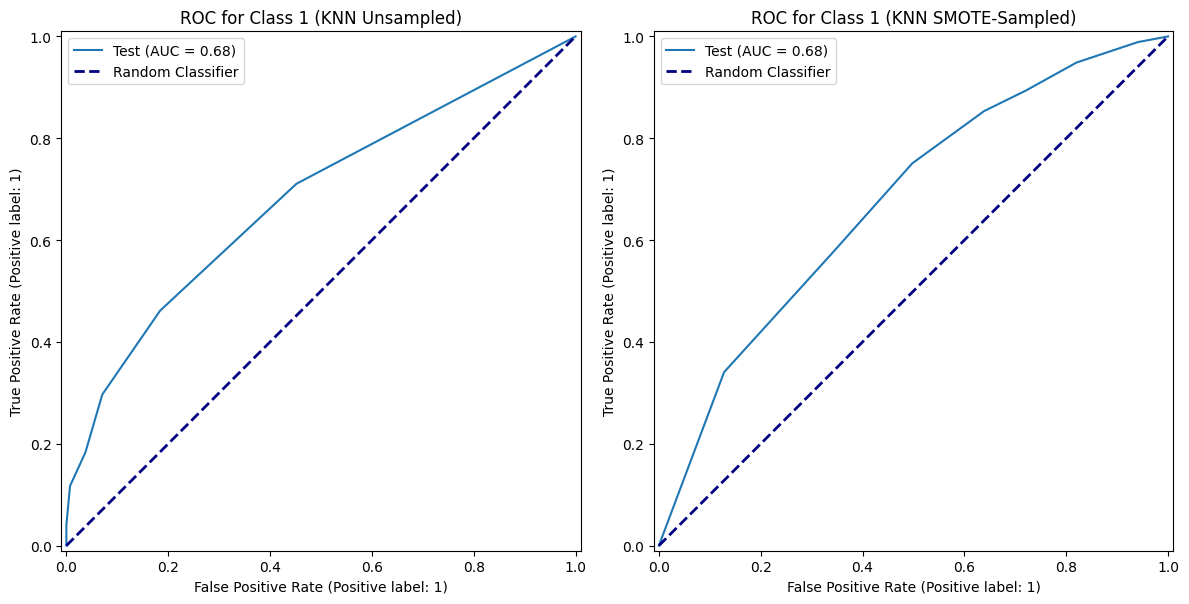

In [245]:
# ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(KNN, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (KNN Unsampled)')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(KNN_sm, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (KNN SMOTE-Sampled)')
plt.tight_layout()
plt.show()

`AUC` stayed the same at 0.68 with a slight flattening to the ROC curve.

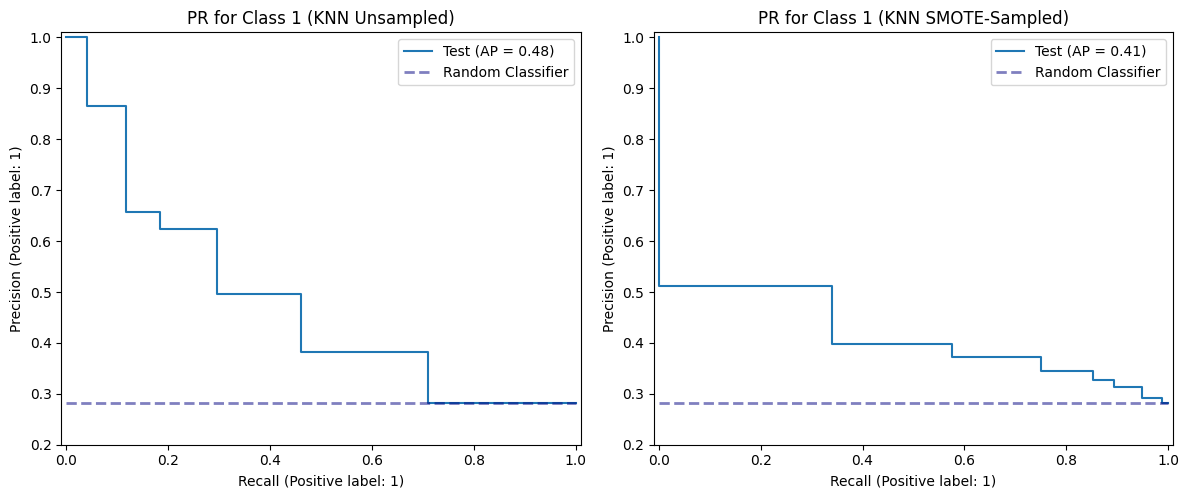

In [246]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(KNN, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (KNN Unsampled)')

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(KNN_sm, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (KNN SMOTE-Sampled)')
plt.tight_layout()
plt.show()

A slight decrease in `AP` from 0.48 to 0.41. However, there is a huge drop off in `Precision` in lower values of `Recall` in the SMOTE set indicating that the new model struggles with `False Positives`.

The same conclusion applies as with the previous two models. ***Overall performance of the model decreased.***

### 4.1.4. <a id='toc4_1_4_'></a>[***Naïve Bayes***](#toc0_)

Where `alpha` = 9.

In [247]:
# Fitting the model
NB_sm = MultinomialNB(alpha=9)
NB_sm.fit(X_remain_sm, y_remain_sm)

# Scores
NB_sm_train_score = NB_sm.score(X_remain_sm, y_remain_sm)
NB_sm_test_score = NB_sm.score(X_test, y_test)

print(f"Train Score: {NB_sm_train_score} \nTest Score: {NB_sm_test_score}")

Train Score: 0.6829618979151689 
Test Score: 0.743801652892562


Comparing both models:

|     | Train Score    | Test Score    |
|-------|-------|-------|
| **Naïve Bayes on Unsampled Data** | 0.827  | 0.784  |
| **Naïve Bayes on SMOTE-sampled Data** | 0.683  | 0.744  |

Although Naïve Bayes has the highest accuracy in the Test set when SMOTE is applied, its previous model still performed better. Note that the train score too a significant hit which may indicate that there may be improvements to be had.

#### 4.1.4.1. <a id='toc4_1_4_1_'></a>[***Evaluation***](#toc0_)

##### 4.1.4.1.1. <a id='toc4_1_4_1_1_'></a>[***Confusion Matrix and Classification Report***](#toc0_)

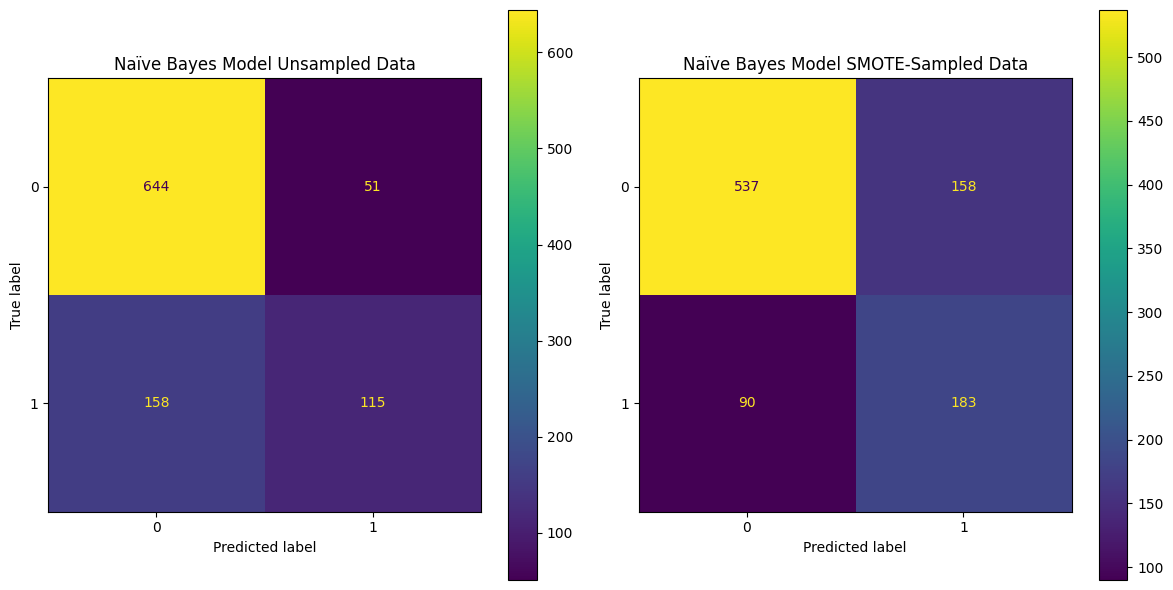

In [248]:
# Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
ConfusionMatrixDisplay.from_estimator(NB, X_test, y_test, ax=ax[0]) # Using scaled data for Logistic Regression
plt.title('Naïve Bayes Model Unsampled Data')
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(NB_sm, X_test, y_test, ax=ax[1]) # Using scaled data for Logistic Regression
plt.title('Naïve Bayes Model SMOTE-Sampled Data')

plt.tight_layout()
plt.show()

In [249]:
# Classification Report
y_pred_DT = DT.predict(X_test)
report_DT = classification_report(y_test, y_pred_DT)
print('NB on Unsampled Data Classification Report')
print(report_DT)

y_pred_NB_sm = NB_sm.predict(X_test)
report_NB_sm = classification_report(y_test, y_pred_NB_sm)
print('\nNB on SMOTE-Sampled Data Classification Report')
print(report_NB_sm)

NB on Unsampled Data Classification Report
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       695
           1       0.85      0.40      0.54       273

    accuracy                           0.81       968
   macro avg       0.83      0.68      0.71       968
weighted avg       0.82      0.81      0.78       968


NB on SMOTE-Sampled Data Classification Report
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       695
           1       0.54      0.67      0.60       273

    accuracy                           0.74       968
   macro avg       0.70      0.72      0.70       968
weighted avg       0.77      0.74      0.75       968



Again, `Recall` has increased significantly for `Class 1` but at the expense of `Precision` in `Class 1` and `Recall` in `Class 0`.

##### 4.1.4.1.2. <a id='toc4_1_4_1_2_'></a>[***ROC and PR Curve***](#toc0_)

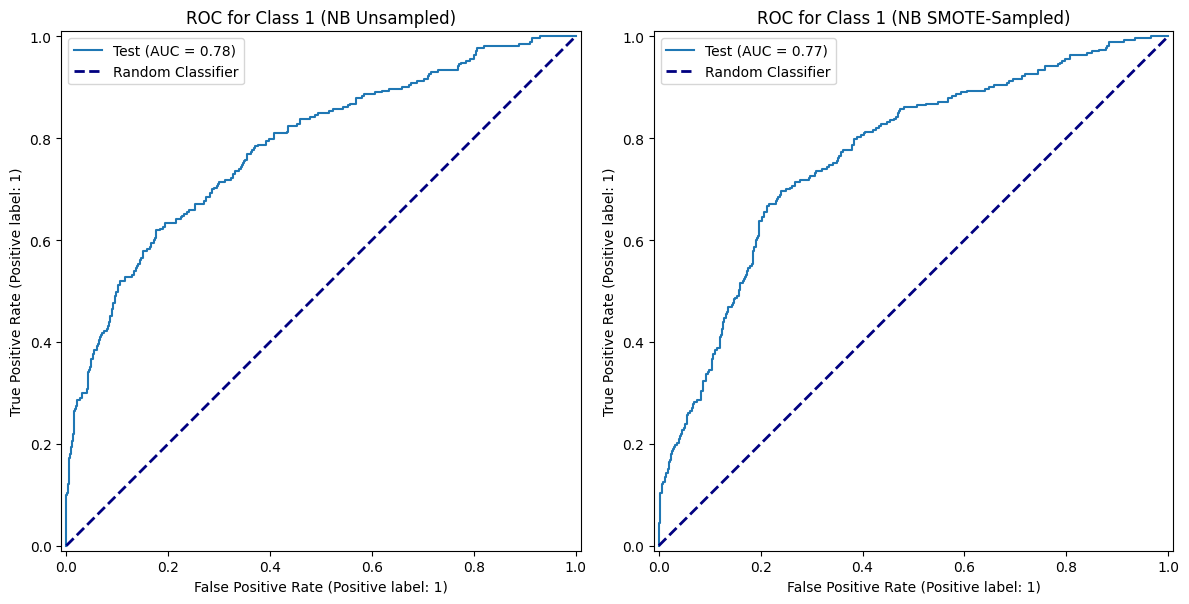

In [250]:
# ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
RocCurveDisplay.from_estimator(NB, X_test, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (NB Unsampled)')

plt.subplot(1, 2, 2)
RocCurveDisplay.from_estimator(NB_sm, X_test, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC for Class 1 (NB SMOTE-Sampled)')
plt.tight_layout()
plt.show()

`AUC` decreased from 0.78 to 0.77 which is only a slight decrease. Notice the kink outward on the SMOTE model.

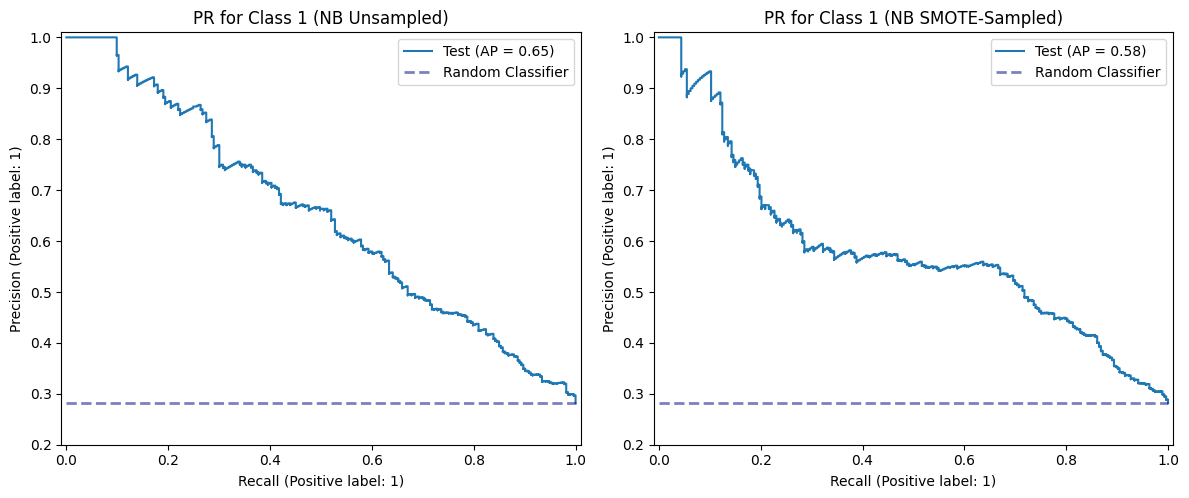

In [251]:
# PR Curve
baseline = (sum(y_test) / len(y_test))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plt.subplot(1, 2, 1)
PrecisionRecallDisplay.from_estimator(NB, X_test, y_test, name='Test', pos_label=1, ax=ax[0])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (NB Unsampled)')

plt.subplot(1, 2, 2)
PrecisionRecallDisplay.from_estimator(NB_sm, X_test, y_test, name='Test', pos_label=1, ax=ax[1])
plt.plot([0, 1], [baseline, baseline], alpha=0.5, color='navy', lw=2, ls='--', label='Random Classifier')
plt.ylim(bottom=0.2)
plt.legend()
plt.title('PR for Class 1 (NB SMOTE-Sampled)')
plt.tight_layout()
plt.show()

`AP` has decreased again from 0.65 to 0.58 for Naïve Bayes. Notice the change from a gradual slope to a more volatile slope of the PR curve. `Precision` is also not preserved as it was pre-SMOTE in lower values of `Recall`. This indicates the model struggling with False Positives which is confirmed by the Confusion Matrix above.

# 5. <a id='toc5_'></a>[**Conclusion/Next Steps**](#toc0_)

- In fitting four base models we have found the performance to be biased towards `Class 0` which is normal for an imbalanced dataset.
- When applying SMOTE (imbalance handling) we have seen that the performance of all four models decreased overall.
  - Although Recall for `Class 1` increased in all models, we have found that this was at the expense of Precision for `Class 1` and Recall in `Class 0`.
  - The outcome in introducing SMOTE is that the models have trouble identifying negative sentiment.

**Next Steps**
1. Experiment with other types of imbalance handling
   1. Near miss (undersampling)
   2. SMOTEENN (a combination of over and undersampling)
   3. Play around with weights in the models to reflect the imbalance (e.g. `class_weight` in `LogisticRegression()`)
2. Incorporate advanced ML techniques
   1. Ensemble Learning
   2. Neural Networks
3. Experiment with other vectorization methods such as TF-IDF and Word2vec
4. Incorporate Sentiment Analysis into Time Series Model

---